# 0. Set up
## 0.1 If if needed, clone Demeter with git

In [ ]:
!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

and install the package

In [ ]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/


print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


## 0.2 After jupyter restart, run :

In [ ]:


import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1. code utile

## imports

In [5]:

import demeter.utils.torchbox as tb
from demeter.constants import *
import demeter.metamorphosis.rotate as mtrt
import demeter.metamorphosis as mt
import demeter.utils.reproducing_kernels as rk
import demeter.utils.axes3dsliders_plt as a3s
import demeter.utils.rigid_exploration as rg
import brats_utils as bu

from scipy.spatial.transform import Rotation as R


# term_width = os.get_terminal_size().columns
term_width = 30


def prepare_momenta(image_shape,
                    image : bool = True,
                    rotation : bool = True,
                    translation : bool = True,
                    rot_prior = None,
                    trans_prior= None,
                    device = "cuda:0",
                    requires_grad = True):
    dim = 2 if len(image_shape) == 4 else 3
    if rot_prior is None:
        rot_prior = torch.zeros((dim,))
    if trans_prior is None:
        trans_prior = [0] * dim
    momenta = {}
    kwargs = {
        "dtype":torch.float32,
        "device":device
    }
    if image:
        momenta["momentum_I"]= torch.zeros(S.shape,**kwargs)
    if rotation:
        if len(rot_prior.shape)==2:
            momenta["momentum_R"] = torch.tensor(rot_prior,**kwargs)
        elif len(rot_prior.shape)==1:
            r1, r2, r3 = rot_prior
            momenta["momentum_R"] = torch.tensor(
            [[0,-r1, -r2 ],
                     [r1, 0, -r3],
                     [r2, r3, 0]],
                    dtype=torch.float32, device='cuda:0')
        else:
            raise ValueError("Rotation prior must be 2 or 1 dimensional")
    if translation:
        momenta["momentum_T"]= torch.tensor(trans_prior,
                                            **kwargs)

    for keys in momenta.keys():
        momenta[keys].requires_grad=requires_grad

    return momenta

def random_affine_def():
    rdm_angle = torch.randn((3,))/4
    rdm_translation = torch.randn((3,))/15

    args_aff = torch.cat(
        [
            rdm_angle,
            rdm_translation,
            torch.ones_like(rdm_angle)
        ], dim = 0
    )
    print(args_aff)

    # args_aff = torch.tensor(
    #         [.6,-.3, 0, # angle
    #         .1,.02,0,   # translation
    #         1,1,1] # scaling
    # )
    aff_mat = tb.create_affine_mat_3d(args_aff)
    print(aff_mat)
    aff_grid = tb.affine_to_grid_3d(aff_mat, img_1.shape[2:])
    return aff_grid, aff_mat


def pixel_to_2square_landmark(landmarks, image_size):
    if len(image_size) > 3:
        image_size = image_size[2:]
    landmarks = landmarks.clone().float()
    for i in range(landmarks.shape[1]):
        landmarks[:,i] *= 2/ (image_size[i] )
    return landmarks - 1

def test_pixel_to_2square_landmark():
    landmarks = torch.tensor(
        [[0,0,0],[240,240,155],[240//2, 240//2, 155//2]]
    )
    img_shape = (1, 1, 240, 240, 155)
    expected_result = torch.tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000, -0.0065]])
    actual_result = pixel_to_2square_landmark(landmarks, img_shape)
    print('landmarks',landmarks)
    print("landmarks processed",pixel_to_2square_landmark(landmarks,img_shape))
    assert expected_result == actual_result
    
def apply_aff_to_landmarks(landmarks, grid):
    """
    Transport landmarks by a deformation grid.
    """
    new_land = torch.zeros_like(landmarks)
    for i, l in enumerate(landmarks):
        new_land[i]  = grid[:, int(l[2]), int(l[1]), int(l[0])]            # Bad orient

    return new_land

def inverse_affine(affine):
    """
    Compute the inverse of the affine transformation.
    """
    rot = affine[:3, :3]
    trans = affine[:3, 3][None]
    inv_rot = rot.T
    inv_trans = - trans.T

    new_aff = torch.cat([inv_rot, inv_trans], dim=1)
    return  torch.cat([new_aff, affine[-1][None]], dim=0)


# Open raw images

/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/utils/axes3dsliders_plt.py:535: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic(self.image.shape)
ic| axes3dsliders_plt.py:535 in __init__()- (1, 240, 240, 155, 1)


torch.Size([6, 3])
torch.Size([1, 1, 240, 240, 155])
torch.Size([1, 1, 240, 240, 155])
landmarks 0 
 tensor([[ 56.,  88.,  70.],
        [ 68., 146., 120.],
        [ 79., 151., 120.],
        [ 73., 121.,  57.],
        [ 52.,  90., 119.],
        [ 46., 106., 107.]])
landmarks 1 
 tensor([[ 59.,  88.,  69.],
        [ 68., 146., 122.],
        [ 76., 154., 120.],
        [ 74., 120.,  57.],
        [ 52.,  90., 120.],
        [ 49., 106., 107.]])


/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/utils/axes3dsliders_plt.py:604: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic(x,y,z)
ic| axes3dsliders_plt.py:604 in _add_lines_on_plt_()- 120, 120, 77


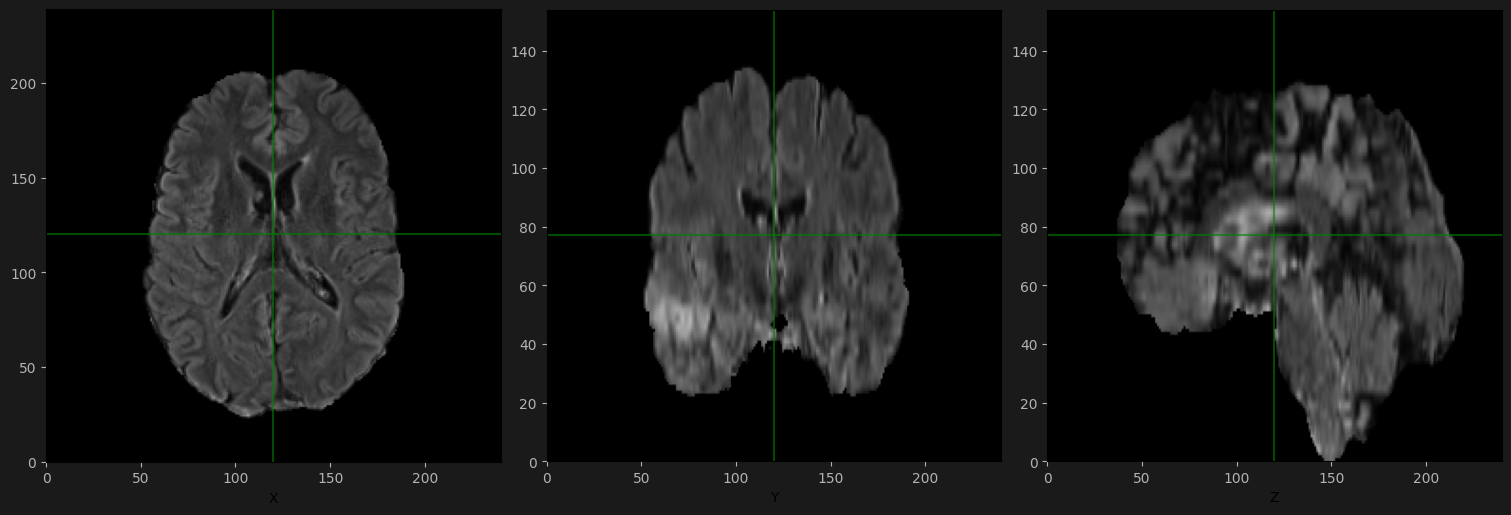

In [4]:
brats_list = [
        # "BraTSReg_086",
        #"BraTSReg_090","BraTSReg_084",
        # "BraTSReg_046",
        # "BraTSReg_002",
    "BraTSReg_021",
    #     "BraTSReg_040",
    # "BraTSReg_118","BraTSReg_114","BraTSReg_132",

        # "BraTSReg_101","BraTSReg_073","BraTSReg_025","BraTSReg_022","BraTSReg_068","BraTSReg_120","BraTSReg_031","BraTSReg_088","BraTSReg_006","BraTSReg_003","BraTSReg_024","BraTSReg_035","BraTSReg_076","BraTSReg_012","BraTSReg_123",
    # 'BraTSReg_034',
    #     'BraTSReg_048',
    # 'BraTSReg_055', 'BraTSReg_082', 'BraTSReg_045', 'BraTSReg_089', 'BraTSReg_057',
        # 'BraTSReg_096', 'BraTSReg_083', 'BraTSReg_042', 'BraTSReg_061', 'BraTSReg_074', 'BraTSReg_097', 'BraTSReg_056', 'BraTSReg_033', 'BraTSReg_136', 'BraTSReg_119', 'BraTSReg_108', 'BraTSReg_054', 'BraTSReg_091', 'BraTSReg_100', 'BraTSReg_030', 'BraTSReg_126', 'BraTSReg_133', 'BraTSReg_138', 'BraTSReg_053', 'BraTSReg_110', 'BraTSReg_079',
    # 'BraTSReg_008', 'BraTSReg_131', 'BraTSReg_001', 'BraTSReg_023', 'BraTSReg_064', 'BraTSReg_067', 'BraTSReg_115', 'BraTSReg_029', 'BraTSReg_093', 'BraTSReg_129', 'BraTSReg_005',
    #  'BraTSReg_140',
        #'BraTSReg_036', 'BraTSReg_071'
    ]


device = 'cuda:0'
valid = False
brats_folder= '2022_valid' if valid else '2022_train'
modality = 'flair'
pb = bu.parse_brats(brats_list=brats_list,brats_folder=brats_folder,modality=modality)
save_folder = None
scale_img = 1

i = 0
img_1,img_2,seg_1,seg_2,landmarks = pb(i,to_torch=True,scale=scale_img,modality=modality)

# img_1 = torch.nn.functional.pad(img_1,(0,0,10,20,0,0), "constant",.5)
print(landmarks[0].shape)
print(img_1.shape)
print(img_2.shape)
# land_2square =  pixel_to_2square_landmark(landmarks[0], img_1.shape)
# ic(landmarks,land_2square)
land_1, land_2 = landmarks
# land_1 =  land_0 +5
print("landmarks 0 \n",land_1)
print("landmarks 1 \n", land_2)
id_grid = tb.make_regular_grid( img_1.shape[2:])

ias = a3s.Image3dAxes_slider(img_1)
plt.show()

In [ ]:
torch.manual_seed(0)
grid, affine = random_affine_def()

# param = torch.tensor([
#     0,0,torch.pi/3,
#     0,0,0,
#     1,1,1
# ])
# affine = tb.create_affine_mat_3d(param)
# grid = tb.affine_to_grid_3d(affine, img_1.shape[2:])
inv_aff = inverse_affine(affine)
inv_grid = tb.affine_to_grid_3d(inv_aff, img_1.shape[2:])

img_1_aff = tb.imgDeform(img_1, grid  )

inv_grid = tb.square2_to_pixel_convention(inv_grid,True)
land_1_aff = apply_aff_to_landmarks(land_1, inv_grid)



print("land_0_aff", land_1_aff)
# a3s.compare_images_with_landmarks(img_1, img_1_aff, land_1, land_1_aff, labels = ["origin", "displaced"])

print("Images ready to be registred")
print("^"*term_width)

source =  img_1_aff.contiguous()
target  = img_2.contiguous()

# Apply Metamorphosis
## barycentre alignement

In [ ]:
print("="*term_width)
print("Barycentre alignement\n")
shape_list = torch.tensor(source.size()[2:])/2
print(source.shape)
print(shape_list)

source_b, target_b, trans_s, trans_t = rg.align_barycentres(source, target, verbose=True)
land_1_b = land_1 - trans_s * shape_list
land_2_b = land_2 - trans_t * shape_list
print(land_1, land_1_b)
print(land_2, land_2_b)
# a3s.compare_images_with_landmarks(source, source_b,
#                                   land_1, land_1_b,
#                                   labels = ["source", "source_barycentred"])
# a3s.compare_images_with_landmarks(target, target_b,land_2, land_2_b,
#                                   labels = ["target", "target_barcentred"])
# a3s.compare_images_with_landmarks(source_b, target_b,
#                                   land_1_b, land_2_b,
#                                   labels = ["source_barycentred", 'target_barcentred'])

## Prepare Metamorphosis optimizer

In [ ]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=1)


mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)

## Rigid Explorator

In [ ]:

# top_params = rg.initial_exploration(mr,r_step=5, verbose=True)
# print(top_params)

top_params =  [
    (torch.tensor(22700.7285), torch.tensor([-3.1416, -0.6283,  1.8850])),
    (torch.tensor(22830.1152), torch.tensor([ 0.6283, -3.1416,  1.8850])),
]

## Optimize Rigid on best values


In [ ]:
# best_loss, best_momentum, best_translation, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)
# rot_def =   tb.apply_rot_mat(mr.mp.id_grid, best_rot.T)
# # rot_def -= best_translation
# img_rot = tb.imgDeform(mr.mp.image, rot_def.to('cpu'),
#                        dx_convention='2square', clamp=True)
#
# a3s.compare_images_with_landmarks(img_rot, source_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "source_b"],)
#
# a3s.compare_images_with_landmarks(img_rot, target_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "target_b"],)

best_momentum = torch.tensor([[ 0.0000,  1.9314,  0.9529],
        [-1.9314,  0.0000, -2.8442],
        [-0.9529,  2.8442,  0.0000]])
best_translation = torch.tensor([ 0.0488, -0.1214, -0.0680])

## Metamorphosis along rigid

In [ ]:
momenta = mtrt.prepare_momenta(
    mr.source.shape,
    image=True,
    rotation=True,
    translation=True,
    rot_prior=best_momentum.detach().clone(),trans_prior=best_translation.detach().clone(),
)
mr = mt.rigid_along_metamorphosis(
    img_1, img_2, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=10
)

# mr = mt.metamorphosis(
#     img_1, img_2, momentum_ini=momenta,
#     kernelOperator= kernelOperator,
#     rho = 1,
#     data_term=datacost ,
#     integration_steps = 10,
#     cost_cst=.1,
#     n_iter=10,
#     grad_coef=1
# )

mr.plot_cost()

a3s.compare_images_with_landmarks(mr.mp.image, img_1,
                                  labels= ["Final", "source"],)
a3s.compare_images_with_landmarks(mr.mp.image, img_2,
                                  labels= ["Final", "target_b"],)